In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [2]:
train_data = pd.read_csv("worked_data_train.csv", index_col = 0)
test_data = pd.read_csv("worked_data_test.csv", index_col = 0)

In [17]:
train_data.select_dtypes(["float64", "int64"])

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,PREV_PRODUCT_COMBINATION_POS mobile with interest,PREV_PRODUCT_COMBINATION_POS mobile without interest,PREV_PRODUCT_COMBINATION_POS other with interest,PREV_PRODUCT_COMBINATION_POS others without interest,INSTALLMENTS_NUM_INSTALMENT_VERSION,INSTALLMENTS_NUM_INSTALMENT_NUMBER,INSTALLMENTS_DAYS_INSTALMENT,INSTALLMENTS_DAYS_ENTRY_PAYMENT,INSTALLMENTS_AMT_INSTALMENT,INSTALLMENTS_AMT_PAYMENT
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,9461.0,637.0,...,0.000000,0.0,1.0,0.0,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765.0,1188.0,...,0.000000,0.0,0.0,0.0,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,19046.0,225.0,...,0.000000,1.0,0.0,0.0,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,19005.0,3039.0,...,0.000000,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,19932.0,3038.0,...,0.166667,0.0,0.0,0.0,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251.0,0.0,0.0,157500.0,254700.0,27558.0,225000.0,0.032561,9327.0,236.0,...,1.000000,0.0,0.0,0.0,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,456252.0,0.0,0.0,72000.0,269550.0,12001.5,225000.0,0.025164,20775.0,NaN,...,0.000000,0.0,0.0,0.0,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,456253.0,0.0,0.0,153000.0,677664.0,29979.0,585000.0,0.005002,14966.0,7921.0,...,1.000000,0.0,0.0,0.0,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,456254.0,1.0,0.0,171000.0,370107.0,20205.0,319500.0,0.005313,11961.0,4786.0,...,0.500000,0.0,0.0,0.0,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


In [3]:
for feature in train_data.select_dtypes("object").columns:
    train_data[feature].fillna(train_data[feature].mode()[0], inplace = True)

for feature in test_data.select_dtypes("object").columns:
    test_data[feature].fillna(train_data[feature].mode()[0], inplace = True)

In [4]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(train_data.select_dtypes("object"))
train_X = pd.DataFrame(encoder.transform(train_data.select_dtypes("object")).toarray())
train_data = train_data.select_dtypes(["float64", "int64"]).merge(train_X, left_index = True, right_index = True)
test_X = pd.DataFrame(encoder.transform(test_data.select_dtypes("object")).toarray())
test_data = test_data.select_dtypes(["float64", "int64"]).merge(test_X, left_index = True, right_index = True)

In [5]:
train_data

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,130,131,132,133,134,135,136,137,138,139
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,9461.0,637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,100003.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765.0,1188.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100004.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,19046.0,225.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,100006.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,19005.0,3039.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,100007.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,19932.0,3038.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251.0,0.0,0.0,157500.0,254700.0,27558.0,225000.0,0.032561,9327.0,236.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
307507,456252.0,0.0,0.0,72000.0,269550.0,12001.5,225000.0,0.025164,20775.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
307508,456253.0,0.0,0.0,153000.0,677664.0,29979.0,585000.0,0.005002,14966.0,7921.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
307509,456254.0,1.0,0.0,171000.0,370107.0,20205.0,319500.0,0.005313,11961.0,4786.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [6]:
for feature in train_data.select_dtypes("float64").columns:
    train_data[feature].fillna(train_data[feature].mean(), inplace = True)
    
for feature in test_data.select_dtypes("float64").columns:
    test_data[feature].fillna(train_data[feature].mean(), inplace = True)
    
for feature in train_data.select_dtypes("int64").columns:
    train_data[feature].fillna(train_data[feature].median(), inplace = True)

for feature in test_data.select_dtypes("int64").columns:
    test_data[feature].fillna(train_data[feature].median(), inplace = True)

In [7]:
train_data.drop(["SK_ID_CURR"], axis = 1, inplace = True)
test_data.drop(["SK_ID_CURR"], axis = 1, inplace = True)

In [36]:
test_data

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,130,131,132,133,134,135,136,137,138,139
0,0.0,135000.0,568800.0,20560.5,450000.0,0.018850,19241.0,2329.0,-5170.0,-812.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,99000.0,222768.0,17370.0,180000.0,0.035792,18064.0,4469.0,-9118.0,-1623.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,202500.0,663264.0,69777.0,630000.0,0.019101,20038.0,4458.0,-2175.0,-3503.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2.0,315000.0,1575000.0,49018.5,1575000.0,0.026392,13976.0,1866.0,-2000.0,-4208.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,180000.0,625500.0,32067.0,625500.0,0.010032,13040.0,2191.0,-4000.0,-4262.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0.0,121500.0,412560.0,17473.5,270000.0,0.002042,19970.0,5169.0,-9094.0,-3399.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
48740,2.0,157500.0,622413.0,31909.5,495000.0,0.035792,11186.0,1149.0,-3015.0,-3003.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
48741,1.0,202500.0,315000.0,33205.5,315000.0,0.026392,15922.0,3037.0,-2681.0,-1504.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
48742,0.0,225000.0,450000.0,25128.0,450000.0,0.018850,13968.0,2731.0,-1461.0,-1364.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [8]:
k_fold = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
folds = []
for train_index, test_index in k_fold.split(train_data, train_data["TARGET"]):
    to_append = {"Train" : train_data.iloc[train_index,], "Test" : train_data.iloc[test_index]}
    folds.append(to_append)

In [9]:
def perform_model(classifier, folds):
    roc_scores = []
    for fold in folds:
        classifier.fit(fold["Train"].drop(["TARGET"], axis = 1).values, fold["Train"]["TARGET"].values)
        probabilities = classifier.predict_proba(fold["Test"].drop(["TARGET"], axis = 1).values)
        roc_scores.append(roc_auc_score(fold["Test"]["TARGET"], probabilities[:, 1]))
    return(sum(roc_scores) / len(roc_scores))

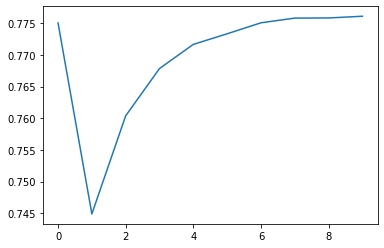

In [12]:
x = list(range(10))
y = []
for max_depth in x:
    y.append(perform_model(lgb.LGBMClassifier(max_depth = max_depth), folds))
sns.lineplot(x = x, y = y)

In [40]:
roc_scores = []
for fold in folds:
    reg = lgb.LGBMClassifier(max_depth = )
    reg.fit(fold["Train"].drop(["TARGET"], axis = 1).values, fold["Train"]["TARGET"].values)
    probabilities = reg.predict_proba(fold["Test"].drop(["TARGET"], axis = 1).values)
    roc_scores.append(roc_auc_score(fold["Test"]["TARGET"], probabilities[:, 1]))
    print("Hey")

Hey
Hey
Hey
Hey
Hey


In [41]:
sum(roc_scores) / len(roc_scores)

0.7750519049268585

In [43]:
roc_scores

[0.7726988527032965,
 0.7768101955565961,
 0.7716533412576326,
 0.777175851884001,
 0.7769212832327663]

In [42]:
reg = lgb.LGBMClassifier()
reg.fit(train_data.drop(["TARGET"], axis = 1).values, train_data["TARGET"].values)
probabilities_test = reg.predict_proba(test_data.values)

In [44]:
test_sk = pd.read_csv("application_test.csv")["SK_ID_CURR"]

In [55]:
final_test = pd.DataFrame({"SK_ID_CURR" : test_sk, "TARGET" : probabilities_test[:, 1]})

In [52]:
len(test_sk)

48744

In [57]:
final_test.to_csv("to_submit.csv", index = False)

In [58]:
final_test = pd.read_csv("to_submit.csv")

In [59]:
final_test

,SK_ID_CURR,TARGET
0,100001,0.030023
1,100005,0.140319
2,100013,0.017900
3,100028,0.026621
4,100038,0.193395
...,...,...
48739,456221,0.082863
48740,456222,0.086399
48741,456223,0.016913
48742,456224,0.036259


NameError: name 'train_data' is not defined